### Imports

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import seaborn as sns

import metabolinks as mtl
import metabolinks.transformations as transf
from metabolinks.similarity import mz_similarity

import scaling as sca
import multianalysis as ma

In [2]:
%matplotlib inline

### Similarity analysis with Metabolights data: 
#### Application of metabolomics and molecular networking in investigating the chemical profile and antitrypanosomal activity of British bluebells (Hyacinthoides non-scripta)
#### Bluebell saponins: Application of metabolomics and molecular networking

Article link: https://www.nature.com/articles/s41598-019-38940-w

Metabolights dataset link: https://www.ebi.ac.uk/metabolights/MTBLS797

Five different tissues of the bluebells plant with different amounts of replicates (unbalanced dataset):
- Bulb - 15 samples.
- Leaves - 6 samples.
- Scapes - 8 samples.
- Shoot - 4 samples (limiting group - 4-fold cross-validation used).
- Flower - 8 samples.

Metabolomics approach:
- Liquid Chromatography – High Resolution Fourier Transform Mass Spectrometry (LC-HRFTMS) Analysis or Orbitrap (both are done).
- No reference masses described/seen so far.
- Obtained in ESI positive and negative modes.
- m/z tolerance used was 0.001, peaks detected above 5.00E4 and minimum time span and tR tolerance was 0.2 minutes. Mass detection performed using centroid mass detector with a noise level set at 1.00E4. Peaks were filtered using FTMS shoulder peaks filter with a mass resolution of 50,000 and the Gaussian peak model.

Data characteristics:
- Large dataset with seemingly no treatment/normalization done beforehand (no normalization mentioned in the paper, reference to a normalization in the Metabolights notes) with around 5600 peaks - no a lot of filtering of m/z peaks was done (peaks had to have 20 times the intensity in relation to a blank solvent). Therefore there seems to be no favoring to binary or conventional methods. 

All further changes to code will first be implemented on the original similarity_analysis. This is an altered version of said original.

To better understand the functions used outside of normal Python packages, see scaling.py and multianalysis.py where they are better described and try to say what is happening in each block of code.

## Similarity analysis

aligned_all_neg = dataset or derived from the dataset (neg isn't particularly correct).

#### Read aligned data and transformation into an AlignedSpectra object with zeros as missing values

In [3]:
file = pd.read_table('Metabolights/m_bluebells_metabolite_profiling_mass_spectrometry_v2_maf.tsv', header=[0], sep='\t')
file = file[file.columns[21:]]
file = file.drop(columns = ['MeOH'])

labels = ["Flower","Leaf","Leaf","Leaf","Flower","Leaf","Flower","Bulb","Shoot","Bulb", "Shoot","Shoot","Shoot","Bulb","Flower",
          "Bulb","Flower","Bulb","Flower","Bulb","Flower","Bulb","Bulb","Scape","Bulb","Scape","Bulb","Scape","Bulb","Scape",
          "Leaf","Leaf","Flower","Bulb","Scape","Bulb","Scape","Bulb","Scape","Bulb","Scape"]
aligned_file = mtl.add_labels(file, labels)

#Replacing 0 values with missing number values for better missing value imputation and feature removal
aligned_all_neg = aligned_file.replace({0:np.nan})

In [4]:
aligned_all_neg

label        Flower          Leaf                                    Flower  \
           Dotsha40      Dotsha19      Dotsha18      Dotsha17      Dotsha39   
0               NaN           NaN           NaN           NaN           NaN   
1      4.640000e+07  1.840000e+08  6.970000e+07  4.460000e+07  4.590000e+07   
2      8.095649e+06  7.804774e+06  7.988827e+06  1.270000e+07  6.586657e+06   
3      1.202926e+06  1.151827e+06  1.183014e+06  1.872705e+06  9.765677e+05   
4      3.098305e+06  4.168573e+06  2.928556e+06  1.237206e+06  3.382604e+06   
...             ...           ...           ...           ...           ...   
5613   9.174162e+06  2.680839e+04  9.408837e+03  1.620303e+04  1.600687e+06   
5614   1.463378e+05  4.080801e+03  3.088507e+03  1.961747e+04  8.449314e+04   
5615   6.645727e+06  1.918537e+04  6.280238e+03  2.135262e+04  1.182814e+06   
5616   7.748957e+04  1.065554e+06  7.640567e+05  5.741906e+05  3.450680e+04   
5617   1.620834e+06  4.505316e+03  5.689073e+03  3.676906e+04  2.127384e+06   

label          Leaf        Flower          Bulb         Shoot          Bulb  \
           Dotsha16      Dotsha38      Dotsha11      Dotsha33      Dotsha10   
0               NaN           NaN           NaN           NaN           NaN   
1      6.227750e+06  5.901142e+06  5.726595e+06  1.840000e+08  6.763794e+06   
2      1.100000e+07  9.402276e+06  1.180000e+07  1.270000e+07  5.915478e+06   
3      1.604615e+06  1.384481e+06  1.739213e+06  1.862370e+06  8.683881e+05   
4      2.168892e+06  3.090600e+06  1.627986e+06  3.015047e+06  1.753696e+06   
...             ...           ...           ...           ...           ...   
5613            NaN  3.336555e+06  3.065502e+05  1.842542e+05  1.205321e+05   
5614   5.089503e+03  4.670739e+05           NaN  2.609991e+03  2.074986e+03   
5615            NaN  1.936013e+06  2.329574e+05  1.047526e+05  8.538362e+04   
5616   1.106852e+04  1.232252e+05           NaN  2.198583e+05           NaN   
5617   2.692773e+03  3.916986e+06  7.065308e+05  7.006039e+04  6.544098e+05   

label  ...          Leaf        Flower          Bulb         Scape  \
       ...      Dotsha20      Dotsha41      Dotsha04      Dotsha26   
0      ...           NaN           NaN           NaN           NaN   
1      ...  6.046481e+06  4.240000e+07  7.685873e+06  1.850000e+07   
2      ...  8.175683e+06  5.061908e+04  2.550000e+07  1.210000e+07   
3      ...  1.183837e+06  3.910975e+03  3.988813e+06  1.749770e+06   
4      ...  3.277548e+06  2.834835e+06  5.809229e+05  3.474607e+06   
...    ...           ...           ...           ...           ...   
5613   ...  5.335112e+04  1.020000e+07  3.056013e+05  2.617688e+06   
5614   ...  3.613783e+03  3.080303e+05  1.688112e+03  3.645795e+05   
5615   ...  9.500124e+03  7.735829e+06  2.215141e+05  1.909581e+06   
5616   ...  8.170254e+05  1.313272e+05           NaN  1.580090e+05   
5617   ...  1.083219e+04  1.053335e+06  2.624605e+05  1.018431e+06   

label          Bulb         Scape          Bulb         Scape          Bulb  \
           Dotsha03      Dotsha25      Dotsha02      Dotsha24      Dotsha01   
0               NaN           NaN           NaN           NaN           NaN   
1      5.834345e+06  1.430000e+09  5.354917e+06  1.830000e+08  5.889334e+06   
2      3.780000e+07  1.300000e+07  1.630000e+07  1.620000e+07  2.400000e+07   
3      5.683933e+06  1.911860e+06  2.404521e+06  2.390582e+06  3.516198e+06   
4      1.294930e+05  2.170068e+06  1.118008e+05  2.456434e+06  2.237740e+04   
...             ...           ...           ...           ...           ...   
5613   8.023726e+05  3.098874e+06  3.217826e+05  4.390905e+06  1.970467e+05   
5614   9.304752e+03  7.595137e+04  2.683473e+03  1.502761e+04           NaN   
5615   5.868644e+05  2.245569e+06  2.361279e+05  3.378023e+06  1.481795e+05   
5616            NaN  2.285876e+05           NaN  1.022654e+05           NaN   
5617   2.125239e+05  5.272674e+05  7.906197e+05  1.955316e+05  2.424737e+05   

label

### Compute m/z similarities

In [5]:
sim_neg = mz_similarity(aligned_all_neg, has_labels = True)

In [6]:
print(sim_neg)


Sample similarity, counts of common peaks
          Dotsha40  Dotsha19  Dotsha18  Dotsha17  Dotsha39  Dotsha16  \
Dotsha40      4184      3817      3842      3890      4021      3804   
Dotsha19      3817      4050      3911      3890      3792      3774   
Dotsha18      3842      3911      4071      3933      3813      3833   
Dotsha17      3890      3890      3933      4129      3856      3888   
Dotsha39      4021      3792      3813      3856      4118      3766   
Dotsha16      3804      3774      3833      3888      3766      4013   
Dotsha38      3992      3835      3839      3869      3984      3780   
Dotsha11      3637      3572      3600      3654      3598      3577   
Dotsha33      3681      3615      3642      3636      3660      3600   
Dotsha10      3566      3487      3518      3590      3532      3503   
Dotsha32      3498      3472      3499      3476      3475      3448   
Dotsha31      3528      3476      3511      3502      3491      3456   
Dotsha30      3735   

### Global metadata for consistency between tables and plots

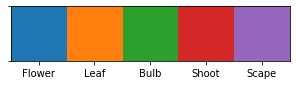

In [7]:
sample_names = aligned_all_neg.cdl.samples
all_labels = aligned_all_neg.cdl.labels
unique_labels = aligned_all_neg.cdl.unique_labels

# customize these colors
colours = sns.color_palette('tab10', 6)

label_colors = {lbl: c for lbl, c in zip(unique_labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(unique_labels)), unique_labels)

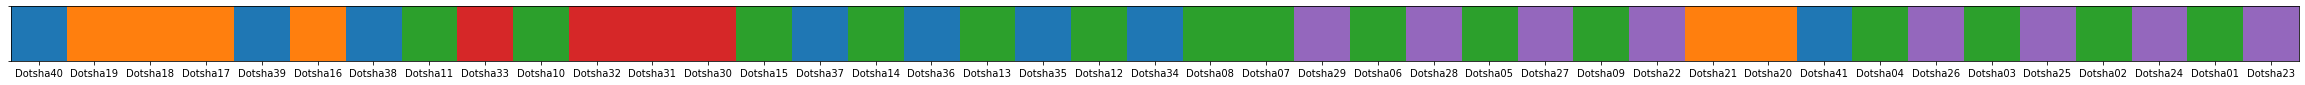

In [8]:
sample_colors = {s: label_colors[lbl] for s, lbl in zip(sample_names, all_labels)}

sns.palplot(sample_colors.values())
new_ticks = plt.xticks(range(len(sample_names)), sample_names)

## Data transformations

### Each Dataset is transformed to binary or ...

3 types of processing are made:

Imp (Ionly) - Only Missing Value Imputation.

P - Missing Value Imputation and Pareto Scaling.

NGP - Missing Value Imputation, glog transformation and Pareto Scaling.

Since the state of the data we have is unknown among the different Metabolights datasets (some are known to have performed some kind of normalization, others there isn't any certainties) and since the reference features also are, for the most part, not known, normalization procedures aren't applied here as they were in previous dataset and the "absence of treatment" in the data is also tested since most of these dataset already suffered some kind of treatment.

In [9]:
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    return df.mask(df.notnull(), 1).mask(df.isnull(), 0)

def compute_transf(dataset, norm_ref=None, lamb=None):
    intensities = dataset
    dicto = {}
    
    imputed = transf.fillna_frac_min(intensities, fraction=0.5)
    if norm_ref is not None:
        norm = transf.normalize_ref_feature(imputed, norm_ref, remove=True)
    else:
        norm = imputed
    P = transf.pareto_scale(imputed)
    #NP = transf.pareto_scale(norm)
    NGP = transf.pareto_scale(transf.glog(norm, lamb=lamb))
    
    dicto['binary'] = df_to_bool(intensities)
    dicto['Ionly'] = imputed
    dicto['P'] = P
    #dicto['NP'] = NP
    dicto['NGP'] = NGP
    
    return dicto

In [10]:
# Dataset
treat_neg = compute_transf(aligned_all_neg)

## Similarity analysis (Jaccard)

In [11]:
def plot_jaccard_sims(dataset, title=''):
    intensities = dataset
    sims = mz_similarity(intensities, has_labels=True)
    #grid_kws = {"height_ratios": (0.4, 0.4, 0.02)}
    f, ax = plt.subplots(1,2, figsize=(14, 7), constrained_layout=True) # gridspec_kw=grid_kws,

    hm = sns.heatmap(sims.sample_similarity_jaccard, annot=False, square=True, ax=ax[0], cmap='YlGnBu', cbar=None)
    hm = sns.heatmap(sims.label_similarity_jaccard, annot=True, square=True, ax=ax[1], cmap='YlGnBu')
    
    #Correction for heatmap bug in latest version of seaborn
    bottom, top = ax[0].get_ylim()
    ax[0].set_ylim(bottom + 0.5, top - 0.5)
    bottom, top = ax[1].get_ylim()
    ax[1].set_ylim(bottom + 0.5, top - 0.5)
    
    ax[0].set_title('Sample similarity')
    ax[1].set_title('Group similarity')
    f.suptitle(title, fontsize=16)

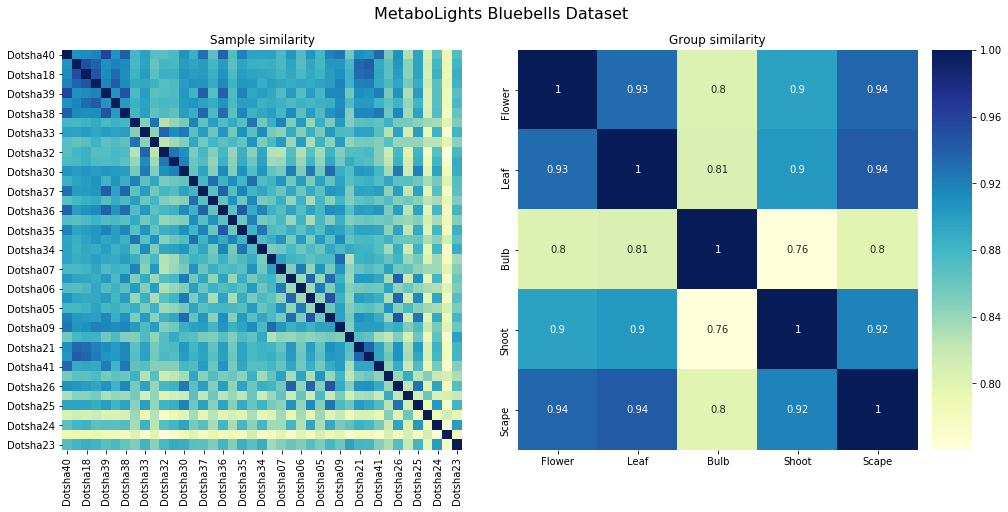

In [12]:
plot_jaccard_sims(aligned_all_neg, 'MetaboLights Bluebells Dataset')

#### Verification that `dist.pdist()` produces the same result as `mz_similarity()`

In [13]:
intensities = aligned_all_neg
neg_01 = treat_neg['binary']

scipy_jdist = dist.pdist(neg_01.T, metric='jaccard')
df_scipy_dist = pd.DataFrame(dist.squareform(scipy_jdist), index=sample_names, columns=sample_names)

#sim_neg = mz_similarity(intensities, has_labels=True)
jsim = sim_neg.sample_similarity_jaccard
#jsim.index.name = 'Sample'
#jsim.columns.name = 'Sample'
jdist = 1 - jsim

from pandas.testing import assert_frame_equal
assert_frame_equal(jdist, df_scipy_dist)
# No exception should be raised!

Dendogram from Jaccard distance, Negative mode MetaboLights FC Dataset (cophenetic = 0.98150)


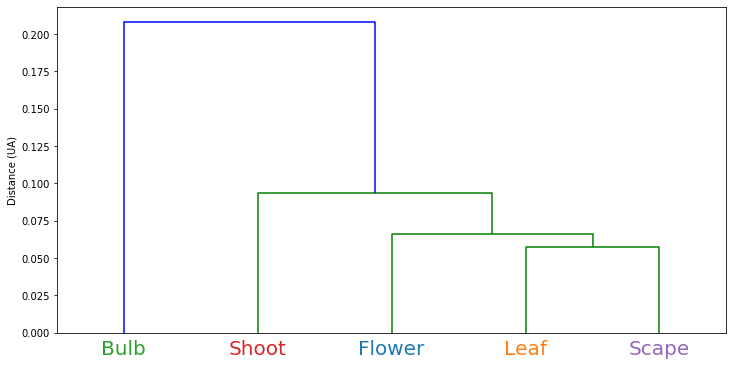

In [14]:
jdist = dist.squareform(1 - sim_neg.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

coph = hier.cophenet(Z,jdist)[0]
print(f'Dendogram from Jaccard distance, Negative mode MetaboLights FC Dataset (cophenetic = {coph:.5f})')

fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

## Hierarchical Cluster Analysis (agglomerative)


### Non-binary Similarity Analysis

All samples need to have missing value imputation with the function fillna_frac_min(dataset, fraction=0.5) of transformation from metabolinks (replace missing features with half of the minimum intensity of the full dataset).

After that, the rest of the data processing can vary where different processing methods were applied in different combinations:

##### Glog transformation/ log2 transformation (glog from transformations in metabolinks) - G;
##### Pareto Scaling (pareto_scale from transformations in metabolinks) - P.
Three combinations were used and compared: No treatment (Imp), only Pareto Scaling (P) and glog transformation and Pareto Scaling (NGP).

In [15]:
def plot_dendogram(Z, title=''):
    fig = plt.figure(figsize=(16,6))
    dn = hier.dendrogram(Z, labels=all_labels, leaf_font_size=15, above_threshold_color='b')
    #Coloring labels
    ax = plt.gca()
    ax.set_ylabel('Distance (UA)')
    ax.set_title(title, fontsize = 13)
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])

### Dendograms with each differently-treated Grapevine Dataset

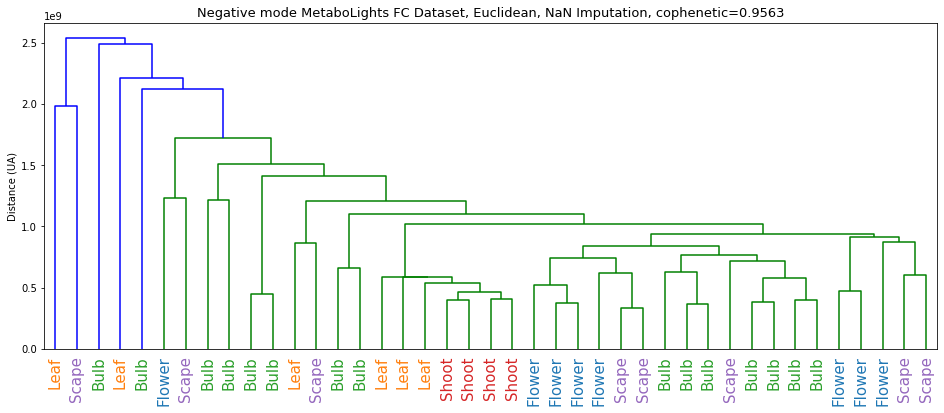

In [16]:
# Missing Value Imputation only
Imp_neg = treat_neg['Ionly']
dist_Imp_neg = dist.pdist(Imp_neg.T, metric = 'euclidean')
Z_Imp_neg = hier.linkage(dist_Imp_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_Imp_neg, dist_Imp_neg)[0]

title = f'Negative mode MetaboLights FC Dataset, Euclidean, NaN Imputation, cophenetic={coph:.4f}'
plot_dendogram(Z_Imp_neg, title)

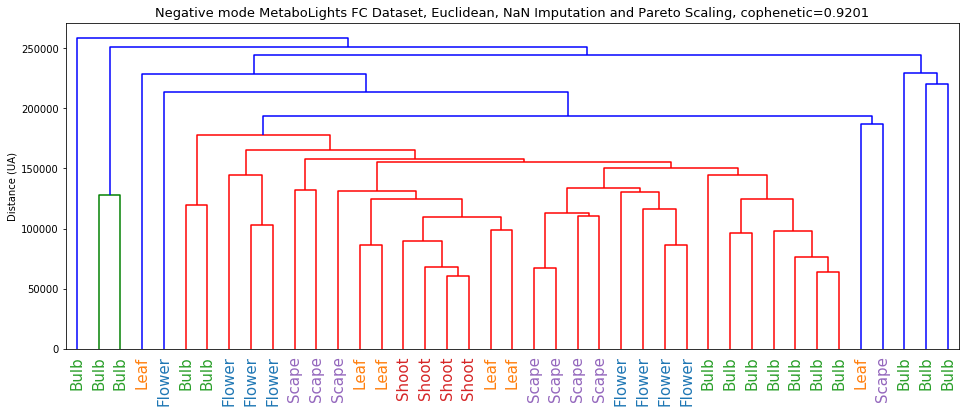

In [17]:
# Imputed and Pareto scaled
P_neg = treat_neg['P']
dist_P_neg = dist.pdist(P_neg.T, metric = 'euclidean')
Z_P_neg = hier.linkage(dist_P_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_neg, dist_P_neg)[0] #method average seems to lead to higher coefficients
title = f'Negative mode MetaboLights FC Dataset, Euclidean, NaN Imputation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_P_neg, title)

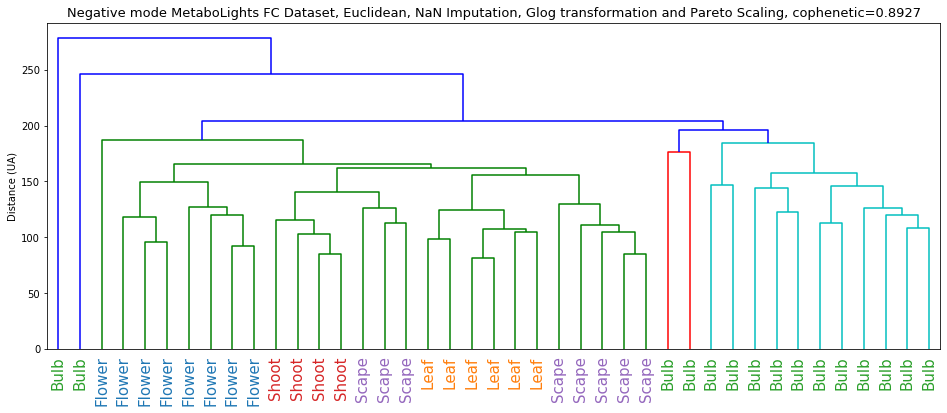

In [18]:
# Imputed, glog transformed and Pareto scaled
NGP_neg = treat_neg['NGP']
dist_NGP_neg = dist.pdist(NGP_neg.T, metric = 'euclidean')
Z_NGP_neg = hier.linkage(dist_NGP_neg, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_neg, dist_NGP_neg)[0] #method average seems to lead to higher coefficients
title = f'Negative mode MetaboLights FC Dataset, Euclidean, NaN Imputation, Glog transformation and Pareto Scaling, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_neg, title)

#### Binary Similarity Analysis Methods - Example Dendogram

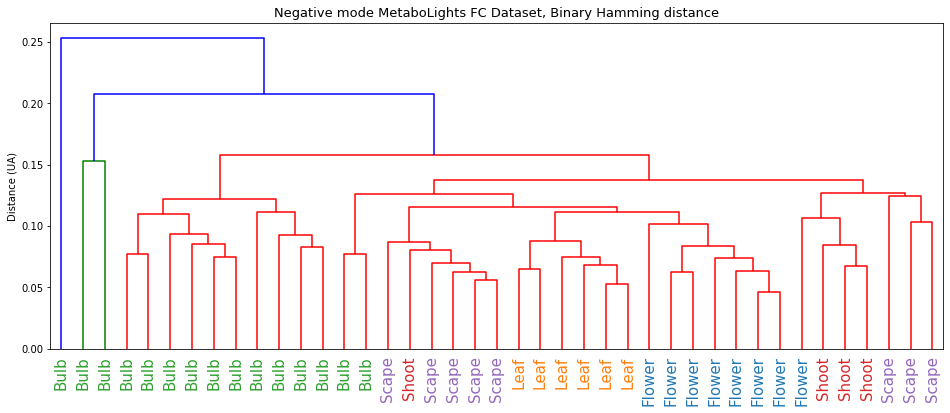

In [19]:
binary = treat_neg['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# print('Yeast dendrogram, Binary methods, Normalized by MetScape')
Zdice = hier.linkage(binary.T, metric='hamming', method='average')

title = f'Negative mode MetaboLights FC Dataset, Binary Hamming distance'
plot_dendogram(Zdice, title)

### Comparing Dendrograms

#### Two methods so far: Baker's Gamma Correlation and Cophenetic Correlation Coefficient

#### Examples of procedure with these methods

#### Baker's method

Use of the mergerank function from multianalysis to create a 'rank' of the iteration number two samples were linked to the same cluster.

In [20]:
euclidean = (Z_Imp_neg, Z_P_neg, Z_NGP_neg)
dist_euclidean = (dist_Imp_neg, dist_P_neg, dist_NGP_neg)

K_BG = []
S_BG = []
Coph_C = []

for i, (eu, d) in enumerate(zip(euclidean, dist_euclidean)):
    K_BG.append(ma.mergerank(eu)) # Mergerank
    S_BG.append(K_BG[i][K_BG[i]!=0]) # Both reshape to a 1D array (needed for spearman correlation) and take out 0's 
    Coph_C.append(hier.cophenet(eu, d)) # Matrix of Cophenetic distances

#### Examples

According to Original Paper (Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors)

In [21]:
print('Pair of samples\tKendall Correlation \tp-value')
print('Imp_neg-P_neg  \t', stats.kendalltau(S_BG[0],S_BG[1])[0], '\t', stats.kendalltau(S_BG[0],S_BG[1])[1])
print('Imp_neg-NGP_neg\t', stats.kendalltau(S_BG[0],S_BG[2])[0], '\t', stats.kendalltau(S_BG[0],S_BG[2])[1])

Pair of samples	Kendall Correlation 	p-value
Imp_neg-P_neg  	 0.5556372384273666 	 8.032725601734389e-214
Imp_neg-NGP_neg	 0.1555600211977252 	 4.527906434631467e-17


According to the explanation given in the R package dendextend

In [22]:
print('Pair of samples\tSpearman Correlation \tp-value')
print('Imp_neg-P_neg  \t', stats.spearmanr(S_BG[0],S_BG[1])[0], '\t', stats.spearmanr(S_BG[0],S_BG[1])[1])
print('Imp_neg-NGP_neg\t', stats.spearmanr(S_BG[0],S_BG[2])[0], '\t', stats.spearmanr(S_BG[0],S_BG[2])[1])

Pair of samples	Spearman Correlation 	p-value
Imp_neg-P_neg  	 0.7292246551259054 	 3.4578182938675225e-272
Imp_neg-NGP_neg	 0.1957849725324691 	 1.2423122579042311e-15


#### Cophenetic Correlation Coefficient

In [23]:
#Acho que se pode aplicar logo a função np.corrcoef visto os elementos que vêm da função cophenet estão sempre na mesma ordem 
#uns em relação aos outros.

In [24]:
print('Pair of samples\tPearson Correlation \tp-value')
print('Imp_neg-P_neg  \t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[1])
print('Imp_neg-NGP_neg\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[1])

Pair of samples	Pearson Correlation 	p-value
Imp_neg-P_neg  	 0.6626133778140488 	 8.539258151001004e-105
Imp_neg-NGP_neg	 0.24951929168791648 	 4.1920589029386617e-13


### Comparison of dendrograms made with all binary metrics and euclidean distances 

#### Correlations between all pairs using all 3 methods

In [25]:
#9 binary methods accepted in pdist (scipy.spatial.distances.pdist)
#binary = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 'yule', 'kulsinski', 'russellrao')
#3 methods that will be used as representative of the others (others not present have similar variations to one of those 3)
binary = ( 'jaccard', 'hamming', 'yule')

In [26]:
aligned_neg = treat_neg['binary']

In [27]:
#Application of all "single" steps needed presented in the examples above with every distance metric.
#Negative mode
Z_neg = []
K_neg = []
S_neg = []
Coph_neg = []

for i in range(len(binary)):
    Z_neg.append(hier.linkage(aligned_neg.T, metric = binary[i], method='average')) #Z
    K_neg.append(ma.mergerank(Z_neg[i])) #Mergerank
    S_neg.append(K_neg[i][K_neg[i]!=0]) #Eliminating 0's
    Coph_neg.append(hier.cophenet(Z_neg[i], dist.pdist(aligned_neg.T, metric = binary[i]))) #Cophenetic

In [28]:
#Creation of a list with all the "rank" values (in order) for the different metrics: 
#Negative Euclideans, Negative Binaries
S = S_BG + S_neg

#Creation of a list with all the returns from the function cophenetic for the different metrics: 
#Negative Euclideans, PNegative Binaries
Coph = Coph_C + Coph_neg

Creation of all dataframes needed to store all correlation coeficients and respective p-values fot all three methods

In [29]:
#Column names and row names for the dataframes
colnames = ['Imp_neg', 'P_neg', 'NGP_neg','jaccard_neg', 'hamming_neg', 'yule_neg']

In [30]:
nS = len(S)
correlations = {key: np.zeros((nS,nS)) for key in ('K', 'S', 'C', 'K_p', 'S_p', 'C_p')}

for i in range(nS):
    for j in range(nS):
        Si, Sj = S[i],S[j]
        # K - Kendall (Baker)
        ktau = stats.kendalltau(Si,Sj)
        correlations['K'][i,j], correlations['K_p'][i,j] = ktau
        # S - Spearman (Baker)
        spearmanr = stats.stats.spearmanr(Si,Sj)
        correlations['S'][i,j], correlations['S_p'][i,j] = spearmanr
        # C - Cophenetic Correlation
        coph = stats.pearsonr(Coph[i][1],Coph[j][1])
        correlations['C'][i,j], correlations['C_p'][i,j] = coph

for k in correlations:
    correlations[k] = pd.DataFrame(correlations[k], columns=colnames, index=colnames)

In [31]:
#Calculation of correlation coefficient for each method

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,nS))* np.nan, columns=colnames, index=[''])
lineV = pd.concat([line.iloc[:,:3], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']), line.iloc[:,3:]], axis = 1)

def prepare_corr_df(df):
    prep = pd.concat([df.iloc[:3], line, df.iloc[3:]])
    prep = pd.concat([prep.iloc[:,:3], lineV.T, prep.iloc[:,3:]], axis = 1)
    return prep

df_KI = prepare_corr_df(correlations['K'])
df_SI = prepare_corr_df(correlations['S'])
df_CI = prepare_corr_df(correlations['C'])

### Heatmaps of the correlation coeficients for the 3 methods

Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 3: Euclidean_DataProcessing_Mode; Last 3: BinaryMetric_Mode


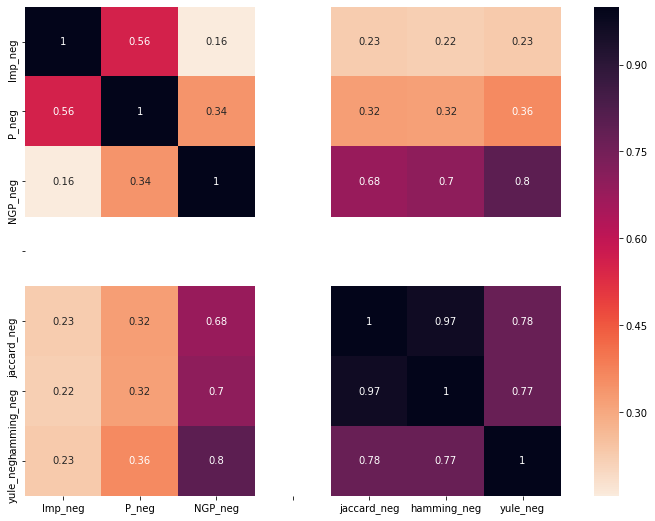

In [32]:
f, ax = plt.subplots(figsize=(12, 9))

print('Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 3: Euclidean_DataProcessing_Mode; Last 3: BinaryMetric_Mode')
hm = sns.heatmap(df_KI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 3: Euclidean_DataProcessing_Mode; Last 3: BinaryMetric_Mode


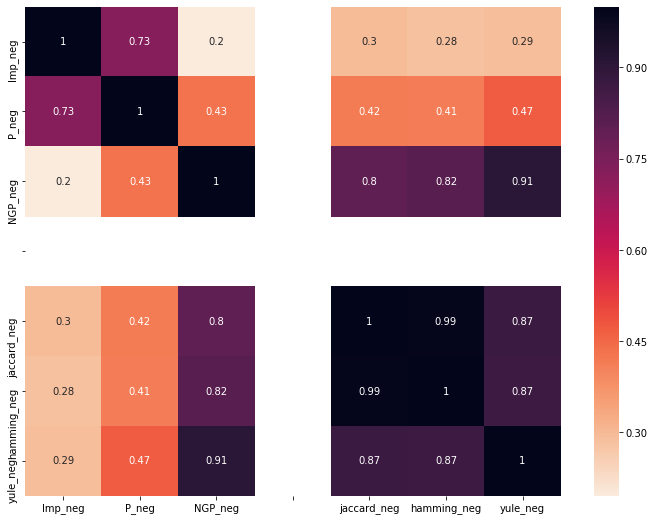

In [33]:
f, ax = plt.subplots(figsize=(12, 9))

print('Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 3: Euclidean_DataProcessing_Mode; Last 3: BinaryMetric_Mode')
hm = sns.heatmap(df_SI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 3: Euclidean_DataProcessing_Mode; Last 3: BinaryMetric_Mode


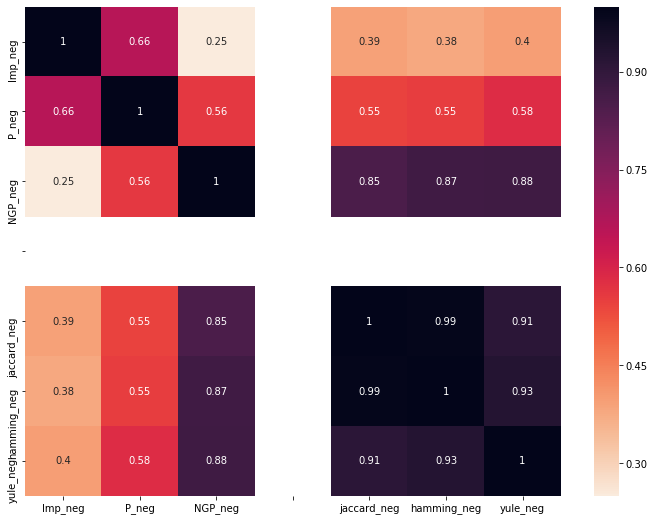

In [34]:
f, ax = plt.subplots(figsize=(12, 9))

print('Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 3: Euclidean_DataProcessing_Mode; Last 3: BinaryMetric_Mode')
hm = sns.heatmap(df_CI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

### Hierarchical clustering of the correlation coeficients of dendrograms made with different distance metrics with each other

Colours for these labels (groups: euclidean_neg, euclidean_pos, neg_binary, pos_binary)

Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode


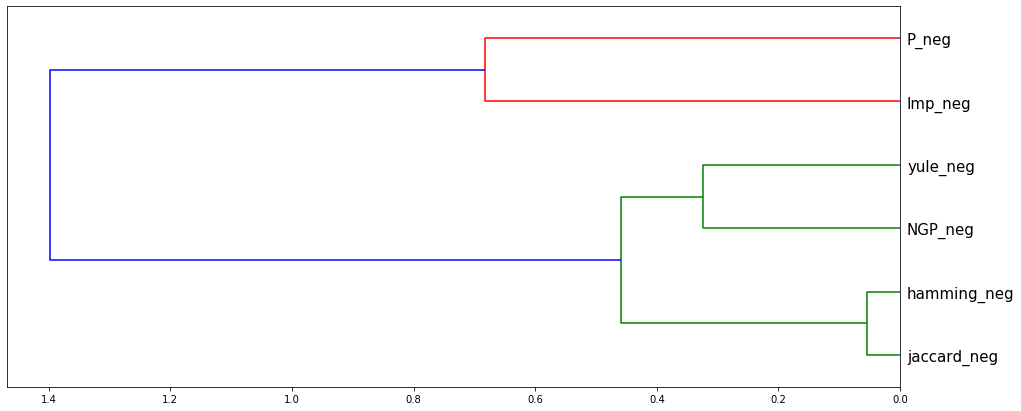

In [35]:
print('Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode')
Z_K = hier.linkage(correlations['K'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_K, labels=correlations['K'].columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')

Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode


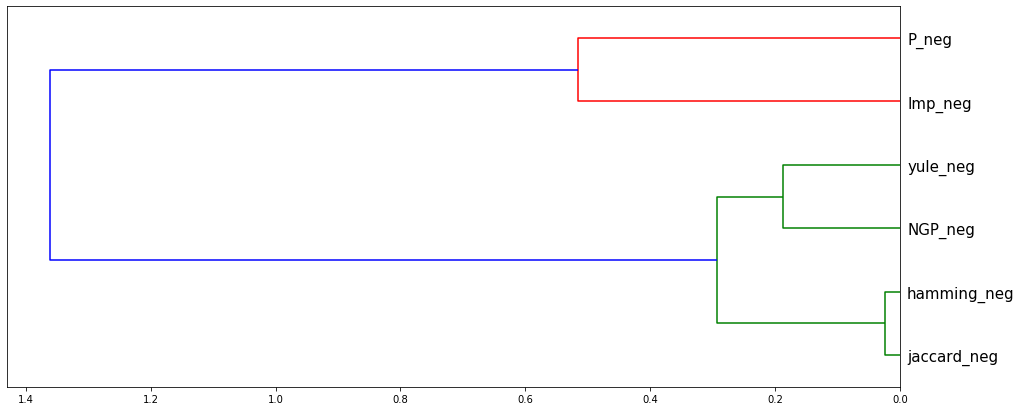

In [36]:
print('Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode')
Z_K = hier.linkage(correlations['S'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_K, labels=correlations['S'].columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')

Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode


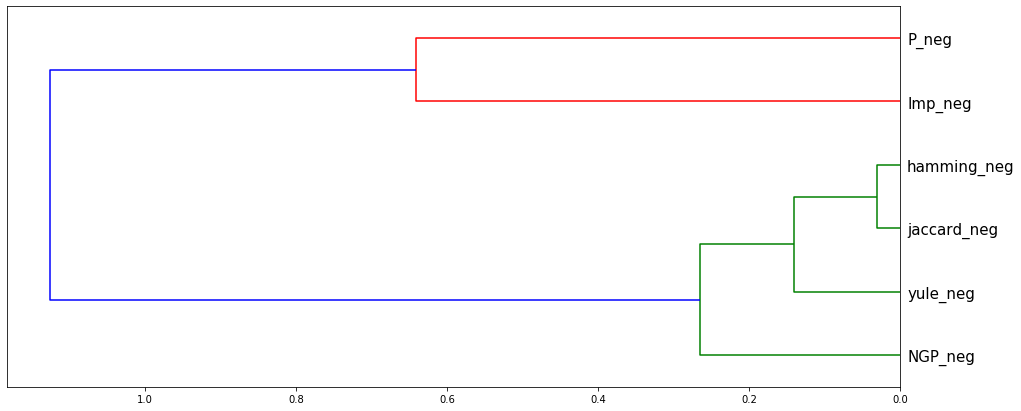

In [37]:
print('Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode')
Z_C = hier.linkage(correlations['C'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_C, labels=correlations['C'].columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')

### Distance discrimination of all methods applied (and shown in previous heatmap/dendrogram).

In [38]:
#Preparing Z linkage matrices
Z = []
Z.extend(euclidean)
Z.extend(Z_neg)

In [39]:
disc_average = np.zeros((1,6))
disc_median = np.zeros((1,6))
disc_correct = np.zeros((1,6))
disc_goodclust = np.zeros((1,6))

for i in range(len(Z)):
    discrim = ma.dist_discrim(aligned_all_neg, Z[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.dist_discrim(aligned_all_neg, Z[i], 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_goodclust[0,i] = ma.good_first_cluster_fraction(aligned_all_neg, Z[i]) #all samples have the same order

#Transforming results into DataFrames    
disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames)
disc_goodclust = pd.DataFrame(disc_goodclust, index = ['% good 1st cluster'], columns = colnames)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:3], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,3:]], axis = 1)
disc_median = pd.concat([disc_median.iloc[:,:3], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances median']).T, disc_median.iloc[:,3:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:3], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,3:]], axis = 1)
disc_goodclust = pd.concat([disc_goodclust.iloc[:,:3], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['% good 1st cluster']).T, disc_goodclust.iloc[:,3:]], axis = 1)

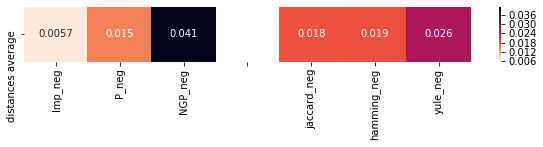

In [40]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
#plt.text(3,-0.2,'Conventional', fontsize  = 12, horizontalalignment='center')
#plt.text(10,-0.2,'Binaries', fontsize = 12, horizontalalignment='center')
plt.show()

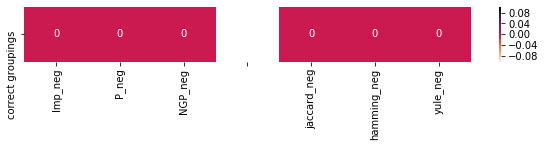

In [41]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

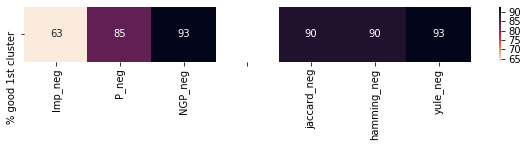

In [42]:
#f, ax = plt.subplots(figsize=(10, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_goodclust*100, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### K-means clustering

In [43]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering and how samples are separated 
Use of the module do sci-kit learn - sklearn. Cluster number equal to the amount of varieties. How well can this method separate the varieties. Default parameters except number of clusters.

This example doesn't necessarily mirror the results below (for the case in example) since K-means clustering has an intrinsically random side to it and the clustering is performed again for the case example.

In [44]:
Kmean = skclust.KMeans(n_clusters=5)

In [45]:
a = Kmean.fit(NGP_neg.T)
#a = Kmean.fit(aligned_neg.T)
a.inertia_

428156.65442714095

In [46]:
dicto = {}

for i, lbl in enumerate(a.labels_):
    dicto.setdefault(lbl, []).append(all_labels[i])
dicto

{0: ['Flower', 'Flower', 'Flower', 'Flower', 'Flower', 'Flower', 'Flower'],
 3: ['Leaf',
  'Leaf',
  'Leaf',
  'Leaf',
  'Scape',
  'Scape',
  'Scape',
  'Leaf',
  'Leaf',
  'Scape'],
 2: ['Bulb',
  'Bulb',
  'Bulb',
  'Bulb',
  'Bulb',
  'Bulb',
  'Bulb',
  'Bulb',
  'Bulb',
  'Bulb',
  'Bulb'],
 4: ['Shoot',
  'Shoot',
  'Shoot',
  'Shoot',
  'Flower',
  'Scape',
  'Scape',
  'Scape',
  'Scape'],
 1: ['Bulb', 'Bulb', 'Bulb', 'Bulb']}

Adjusted Rand Index

In [47]:
from sklearn.metrics import adjusted_rand_score
a.labels_
NGP_neg.cdl.labels
adjusted_rand_score(NGP_neg.cdl.labels,a.labels_)

0.5782043941887927

### K-means clustering applied to all euclidean methods and the binary matrixes built

To try and get a condensed and more easily digestible version of the results, a method similar to the discrimination distance performed in the hierarchical clustering was made. The same metrics as before are used.

Replicates of a variety can be together in a cluster but, if there are more samples in the same cluster, its "discrimination distance" is still zero. Therefore, this method is harsher than the original dist_discrim method. The distance is calculated as the distance between the centroid of the cluster where the samples are and the closest centroid. This distance is normalized by dividing it by the maximum distance between any 2 centroids of the clusters formed. The mean/median of the discrimination distances of all groups is then a measure of the global discrimination distance

Use of the `Kmeans_discrim` function from multianalysis to calculate discrimination distance.

In [48]:
colnames2 = ['Imp_neg', 'P_neg', 'NGP_neg', 'aligned_neg']

In [49]:
Data = (Imp_neg, P_neg, NGP_neg, aligned_neg)

In [50]:
disc_average = np.zeros((1,4))
disc_median = np.zeros((1,4))
disc_correct = np.zeros((1,4))
disc_rand = np.zeros((1,4))

for i in range(len(Data)):
    discrim = ma.Kmeans_discrim(Data[i], method = 'average', iter_num=150, best_fraction=0.1)
    
    #Lists for the results of the best k-means clustering
    average = []
    correct = []
    rand = []
    for j in discrim:
        average.append(discrim[j][0]) #Discrimination Distances
        all_correct = np.array(list(discrim[j][1].values()))
        correct.append(len(all_correct[all_correct>0])) #Correct Clustering Percentages
        rand.append(discrim[j][2]) #Rand Index
    
    #Putting results into the arrays - median of the best k-means clustering
    disc_average[0,i] = np.median(average) 
    disc_correct[0,i] = np.median(correct)
    disc_rand[0,i] = np.median(rand)

#Transforming into DataFrame
disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames2)
disc_correct = pd.DataFrame(disc_correct/5*100, index = ['correct groupings'], columns = colnames2)
disc_rand = pd.DataFrame(disc_rand, index = ['correct groupings'], columns = colnames2)

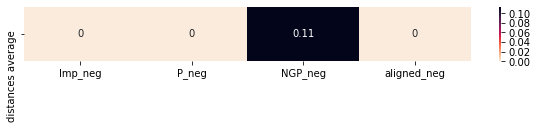

In [51]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.show()

In [52]:
#f, ax = plt.subplots(figsize=(10, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

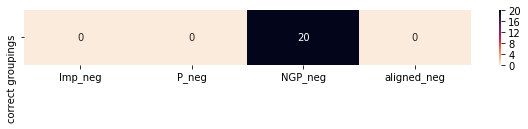

In [53]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

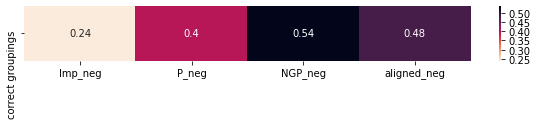

In [54]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_rand, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### RandomForests Attempts - 4-fold cross-validation, n_estimators = 200

This section of the notebook takes some time.

### Test number of trees needed for convergence for N, NP, NGP and binary data (both alignments)

Grid search of number of trees from 10 to 1000 for the random forests. See where the cross-validation score stops improving for each one.

#### Takes  considerable time

In [55]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
#Vector with values for the parameter n_estimators
values = {'n_estimators': range(10,450,10)}

rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv = 4)

In [56]:
# Centralize data information in a dictionary
datasets = {}

datasets['I_neg'] = treat_neg['Ionly']
datasets['P_neg'] = treat_neg['P']
datasets['NGP_neg'] = treat_neg['NGP']
datasets['bin_neg'] = treat_neg['binary']

In [57]:
param = []
test_score = []
for name, dataset in datasets.items():
    print('Fitting', name, '...', end=' ')
    clf.fit(dataset.T, all_labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])
    print('Done!')

Fitting I_neg ... 

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Done!
Fitting P_neg ... 

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Done!
Fitting NGP_neg ... 

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Done!
Fitting bin_neg ... 

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Done!


Performance based on number of trees - Negative Mode


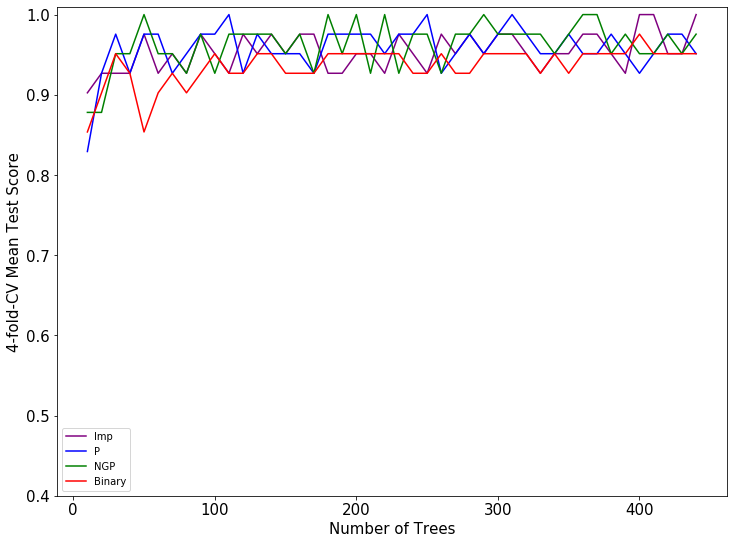

In [58]:
f, ax = plt.subplots(figsize=(12,9))
color = ['purple','blue','green','red']
for i in range(0,4):
    plt.plot(param[i], test_score[i], color = color[i])
plt.ylabel('4-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('Imp', 'P', 'NGP', 'Binary'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Negative Mode')

### Performance of N, NP and NGP data treatments

See performance of all treatments and absence of them using method nº1 (simple application of random forests), see below.

In [59]:
Teste = {}
Teste_std = {}
Teste_feat = {}

In [60]:
for name, data in datasets.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data, n_fold = 4) #, iter_num = 100)
    Teste[name] = rf
    Teste_std[name] = np.std(rf)
    Teste_feat[name] = imp_features
    print(f'done')    

Fitting random forest for I_neg ...done
Fitting random forest for P_neg ...done
Fitting random forest for NGP_neg ...done
Fitting random forest for bin_neg ...done


Accuracy based on the dataset


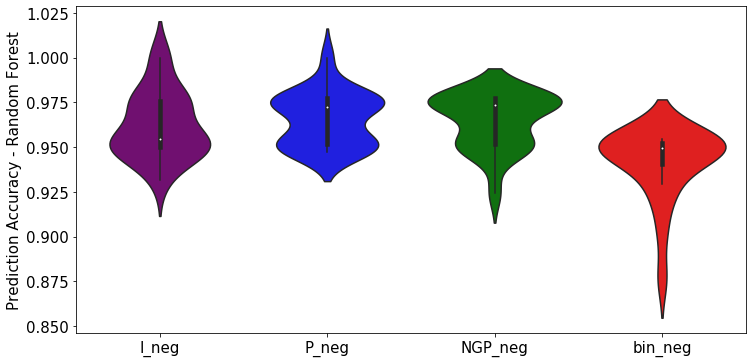

In [61]:
f, ax = plt.subplots(figsize=(12,6))
colors = ['purple','blue','green','red']
sns.violinplot(data=pd.DataFrame.from_dict(Teste), palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - Random Forest', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 15)
print('Accuracy based on the dataset')

In [62]:
Teste_A = {}
for i in Teste:
    Teste_A[i] = np.median(Teste[i])

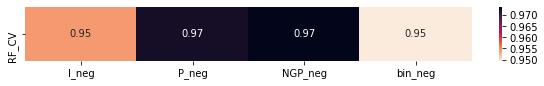

In [63]:
Teste_H = pd.DataFrame(list(Teste_A.values()), index = Teste_A.keys(), columns = ['Accuracy']).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Teste_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV'])

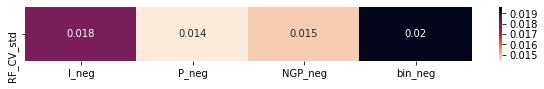

In [64]:
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Teste_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

In [65]:
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
Teste_ic = Teste_std_H / (100**0.5)*1.96

In [66]:
#sns.set_context('notebook')

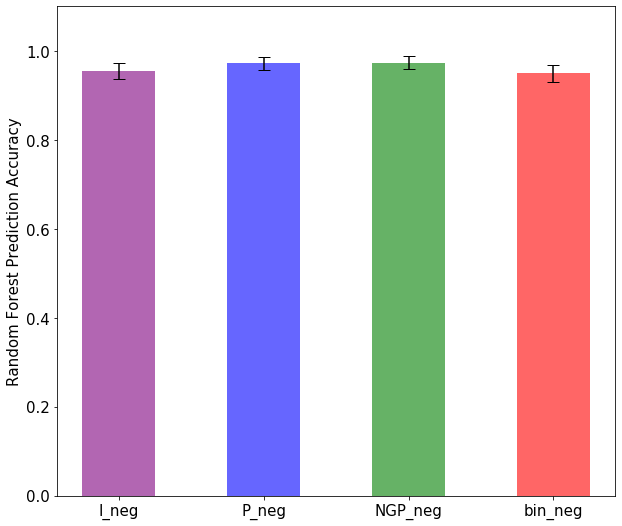

In [67]:
f, ax = plt.subplots(figsize=(10, 9))
#sns.set_context('talk')
color = ['purple','blue','green','red']
plt.bar(height = Teste_H.T['Accuracy'], x = Teste_H.columns, width = 0.5, color = color, alpha = 0.6)
ax.errorbar(x = Teste_H.columns, y = Teste_H.T['Accuracy'], yerr = Teste_std_H.iloc[0,:], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1.10)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show()

### Attempt/Method nº1 - Direct

### Simple application of random forests

The random forest classification is iterated iter_num times to make sure more combinations of training and test samples are used. Then, an average of the results are obtained. 

N-fold Cross-Validation is used as an internal validation system evaluating the performance of the model based on its score/prediction accuracy - the number of folds used will be the one that seems most appropriate in each case. For balanced datasets n_fold = number of replicates in each group if the number of replicates is under 10.

Besides the n-fold cross-validation score, the order of the average of most important features across the random forests (with each iteration and group in cross-validation having the same weight) is extracted from the forests "built".

Application of the function `simple_RF` from multianalysis.

### Characteristics of the features seen as important in the different alignments, data treatments and modes (negative and positive)

We take the 2% most important features in each case and calculate the average number of samples those features appear (samples_m), the average number of different groups/varieties those features appear in (groups_n) and the ratio between these two measures (ratio_m). We also see how many times the importance of the most importante feature is greater than the average importance of a feature in each case ('magni') as well as the % of the model explained (that use) the 2% of the most important features ('more').

A swarmplot is also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

In [68]:
#Getting the number of samples, groups, ratios for each important feature, 
#magnitude for most important feature and calculating % explained by these features (more)
ev = []
magni = []
more = []
for name in Teste_feat:#['neg2-1_direct']:
    
    Spectra = aligned_all_neg
        
    imp_features = Teste_feat[name]
    
    ratio = []
    nsamples = []
    n_groups = []
    
    #Top 2%
    number = round(0.02*len(Spectra))
    magni.append(imp_features[0][1]/(1/len(Spectra)))
    
    a = 0
    for i in range(number): 
        a = a + imp_features[i][1]*100 
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    more.append(a)
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)
#print(ev[4])

In [69]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = [i  for i in Teste_feat])
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)

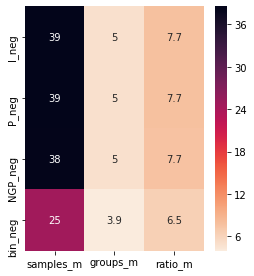

In [70]:
f, ax = plt.subplots(figsize=(4, 4.5))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

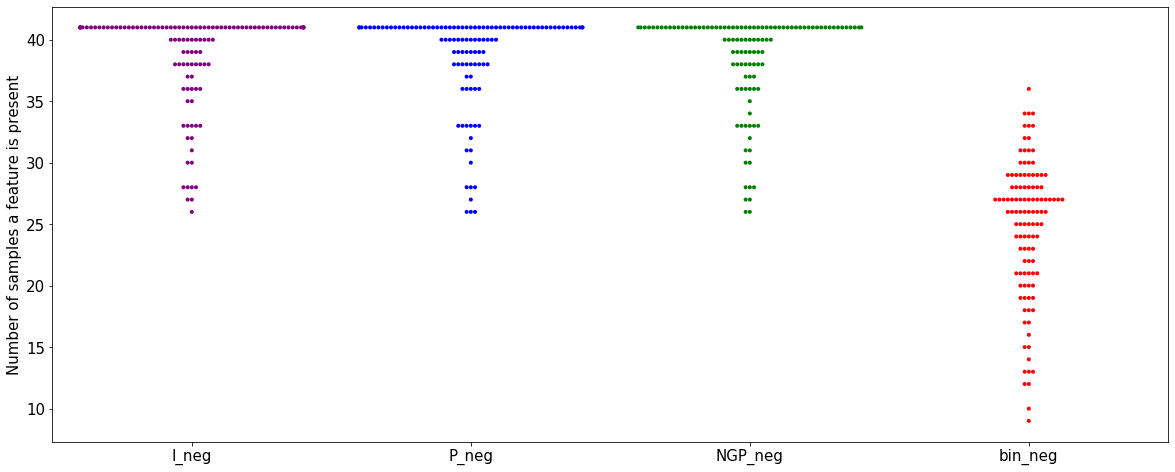

In [71]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data, size = 4, palette = ['purple','blue','green','red'])
ax.set(xticklabels = [list(Teste_feat.keys())[i][0:13] for i in range(len(Teste_feat.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [72]:
print('Magnitude of most important feature:', )
for i in range(4):
    print(list(Teste_feat.keys())[i], '     \t', magni[i])
    
print('\n')
print('% of model explained by the 2% most important features')
for i in range(4):
    print(list(Teste_feat.keys())[i], '     \t', more[i])

Magnitude of most important feature:
I_neg      	 14.069653514677299
P_neg      	 14.180869637025669
NGP_neg      	 14.297422274566356
bin_neg      	 40.02516861435784


% of model explained by the 2% most important features
I_neg      	 17.89222758687083
P_neg      	 17.741417473456472
NGP_neg      	 18.05783958120445
bin_neg      	 30.538610692721402


### PLS-DA - Classification based on Partial Least Squares - Discriminant Analysis

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong).

### Search for the best number of components to use

Strategy: Perform PLS-DA with different number of components and observe the score (both given directly by the method and the r2 score) and the mean-squared error (MSE) of the models built with n-fold cross-validation (same judgement as the one done in the random forests for the cross-validation). Then plot the different results obtained and see at which point (number of components) the score and the MSE stops start approaching a "stable value".

The maximum number of components tested was 50 (which was enough for the objective established above).

Warnings are due to the type of scoring that will be changed in the next version of scikit learn.

Function `optim_PLS` in multianalysis.py - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp.

In [73]:
PLS_optim = {}

In [74]:
%%capture --no-stdout
for name, data in datasets.items():
    print(f'Optimizing PLS-DA for {name} ...', end='')
    CVs, CVr2s, MSEs = ma.optim_PLS(data, max_comp = 20, n_fold = 4)
    PLS_optim[name] = CVs
    print(f'done')    

Optimizing PLS-DA for I_neg ...done
Optimizing PLS-DA for P_neg ...done
Optimizing PLS-DA for NGP_neg ...done
Optimizing PLS-DA for bin_neg ...done


Performance based on number of components


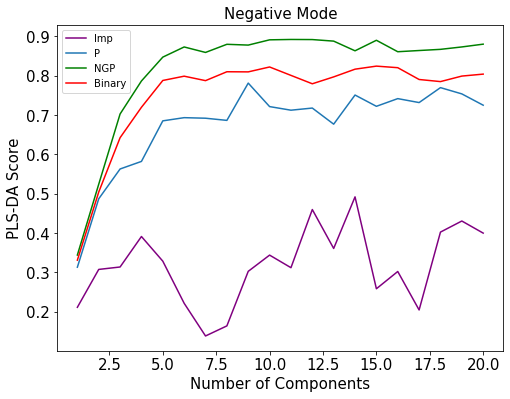

In [75]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,21),PLS_optim['I_neg'], color = 'purple')
plt.plot(range(1,21),PLS_optim['P_neg'])
plt.plot(range(1,21),PLS_optim['NGP_neg'], color = 'green')
plt.plot(range(1,21),PLS_optim['bin_neg'], color = 'red')
plt.ylabel('PLS-DA Score', fontsize = 15)
plt.xlabel('Number of Components', fontsize = 15)
plt.title('Negative Mode', fontsize=15)
ax.legend(('Imp', 'P', 'NGP', 'Binary'))
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of components')

### Application of PLS-DA

The number of components where the evaluating metrics stopped getting considerably better was the numebr of components used in each case. 

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule.

Two metrics to evaluate the results were evaluated. First the score of the model as seen before but more importantly the second one is the accuracy of the model based on the decision rule stated above. All samples are tested once in k different groups as k-fold cross-validation.

In [76]:
PLS_accu = {}
PLS_score = {}
PLS_feat = {}

In [77]:
%%capture --no-stdout
for name, data in datasets.items():
    print(f'Fitting PLS-DA for {name} ...', end='')
    accu, score, u, imp_features = ma.model_PLSDA(data, n_comp = 8, iter_num = 100, n_fold = 4, feat_type = 'Coef')
    PLS_accu[name] = accu
    PLS_score[name] = score
    PLS_feat[name] = imp_features
    print(f'done')    

Fitting PLS-DA for I_neg ...done
Fitting PLS-DA for P_neg ...done
Fitting PLS-DA for NGP_neg ...done
Fitting PLS-DA for bin_neg ...done


Accuracy based on the dataset


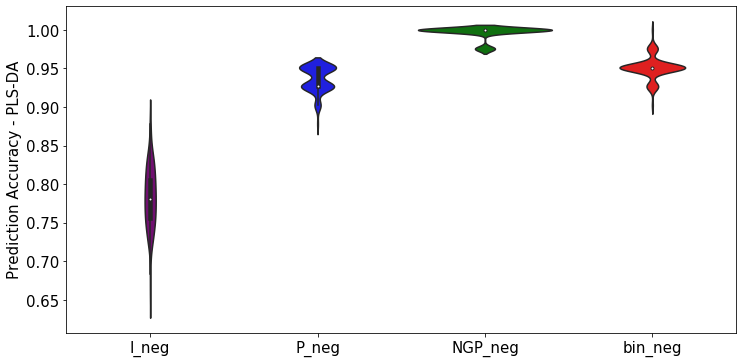

In [78]:
f, ax = plt.subplots(figsize=(12,6))
colors = ['purple','blue','green','red']
sns.violinplot(data=pd.DataFrame.from_dict(PLS_accu), palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 15)
print('Accuracy based on the dataset')

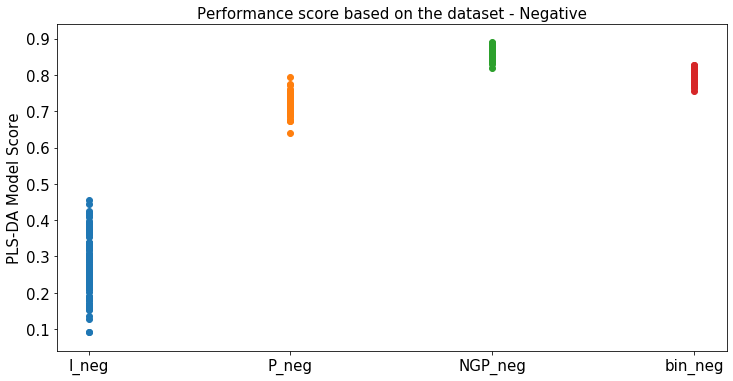

In [79]:
f, ax = plt.subplots(figsize=(12,6))
for name, data in PLS_score.items():
    plt.scatter([name]*len(data), data)
plt.ylabel('PLS-DA Model Score', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('Performance score based on the dataset - Negative', fontsize = 15)
plt.show()

### Medians but also still with standard deviations

In [80]:
Accuracy = {}
Score = {}
Accuracy_std = {}
Score_std = {}
for name in PLS_score.keys():
    Accuracy[name] = np.median(PLS_accu[name])
    Score[name] = np.median(PLS_score[name])
    
    Accuracy_std[name] = np.std(PLS_accu[name])
    Score_std[name] = np.std(PLS_score[name])

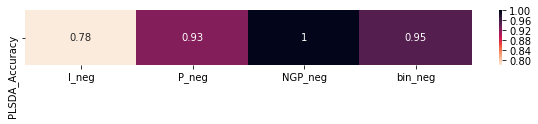

In [81]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T

f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])

plt.show()

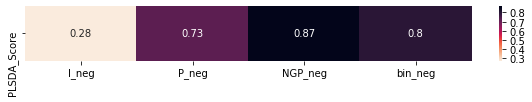

In [82]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys()).T

f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Score_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Score'])

In [83]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys(), columns  = ['Accuracy']).T
Accuracy_H.loc['SD'] = list(Accuracy_std.values())
Accuracy_H.T

,Accuracy,SD
I_neg,0.780488,0.039704
P_neg,0.926829,0.016463
NGP_neg,1.000000,0.008203
bin_neg,0.951220,0.014009


In [84]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys(), columns  = ['Score']).T
Score_H.loc['SD'] = list(Score_std.values())
Score_H.T

,Score,SD
I_neg,0.275813,0.081687
P_neg,0.725734,0.024629
NGP_neg,0.867474,0.013117
bin_neg,0.801505,0.014425


### Characteristics of the most important features

The characteristics of the most important features for each of the methods is done by the same process as applied in the random forests section of the notebook.

In [85]:
#Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature 
ev = []
magni = []
index = []

for name in PLS_feat:
    
    Spectra = aligned_all_neg
    
    imp_features = PLS_feat[name]
    
    index.append(name)
    ratio = []
    nsamples = []
    n_groups = []
    
    #Top 2%
    number = round(0.02*len(Spectra))
    total_m = 0
    
    for i in range(len(imp_features)):
        total_m = total_m + imp_features[i][1]
    magni.append(imp_features[0][1]/(total_m/len(Spectra)))
    for i in range(number): 
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)

In [86]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = index)
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m

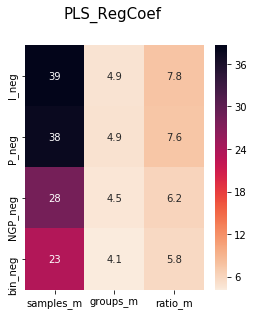

In [87]:
f, ax = plt.subplots(figsize=(4, 4.5))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.suptitle('PLS_RegCoef', fontsize = 15, x = 0.43, y = 1)
plt.show()

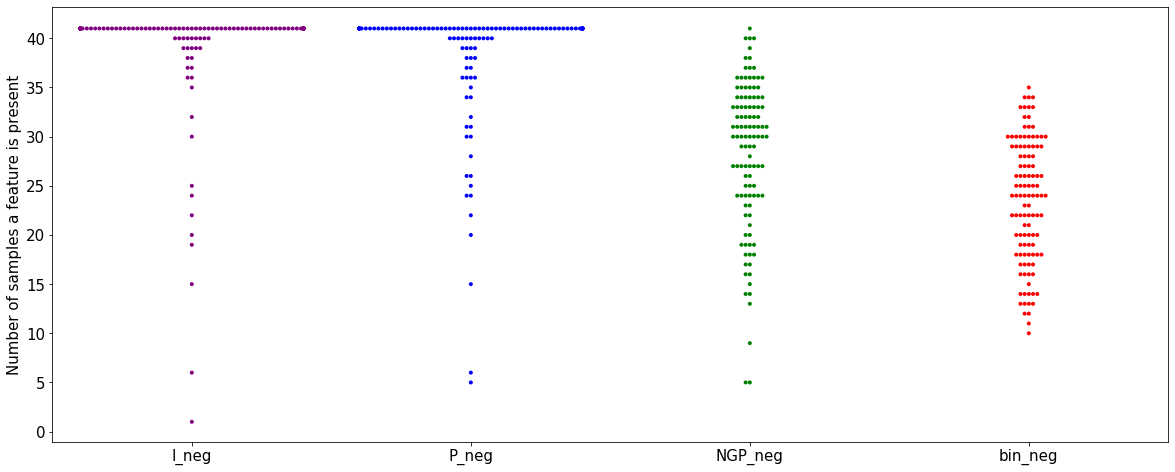

In [88]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]

sns.swarmplot(data=data, size = 4, palette = ['purple','blue','green','red'])
ax.set(xticklabels = [list(PLS_feat.keys())[i] for i in range(len(PLS_feat.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

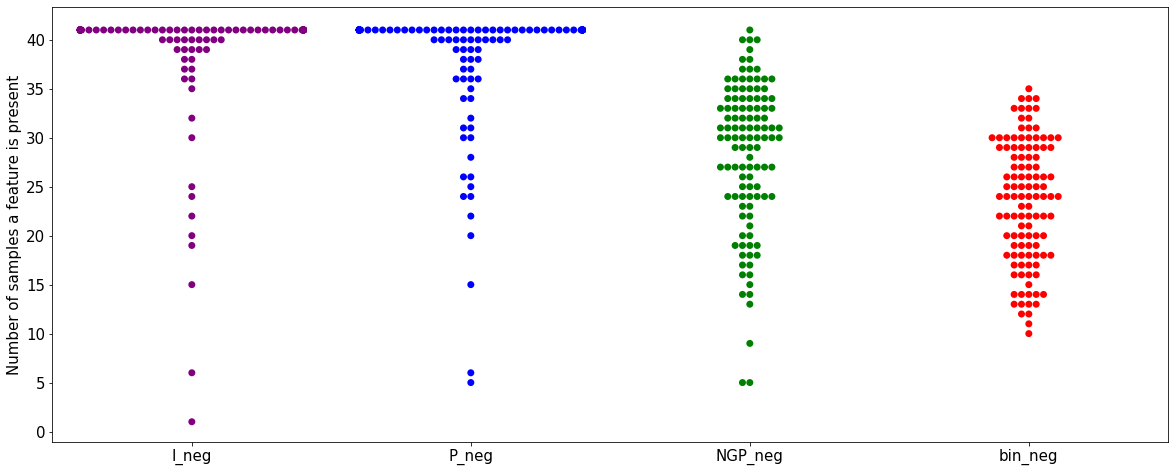

In [89]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]

sns.swarmplot(data=data, size = 7, palette = ['purple','blue','green','red']*2)
ax.set(xticklabels = [list(PLS_feat.keys())[i] for i in range(len(PLS_feat.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

### Example of models built with the full dataset and sample representation on the two most important Components/Latent Variables

In [90]:
def plot_PLSDA(principaldf, label_colors, components=(1,2), title="PLS-DA", ax=None):
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    with sns.axes_style("whitegrid"):
        #ax.axis('equal')
        ax.set_xlabel(f'{col_c1_name}', fontsize = 15)
        ax.set_ylabel(f'{col_c2_name}', fontsize = 15)

        unique_labels = principaldf['Label'].unique()

        for lbl in unique_labels:
            subset = principaldf[principaldf['Label']==lbl]
            ax.scatter(subset[col_c1_name],
                       subset[col_c2_name],
                       s=50, color=label_colors[lbl], label=lbl)

        ax.legend(framealpha=1)
        ax.set_title(title, fontsize=15)

#### NGP data treatment for the Negative Mode

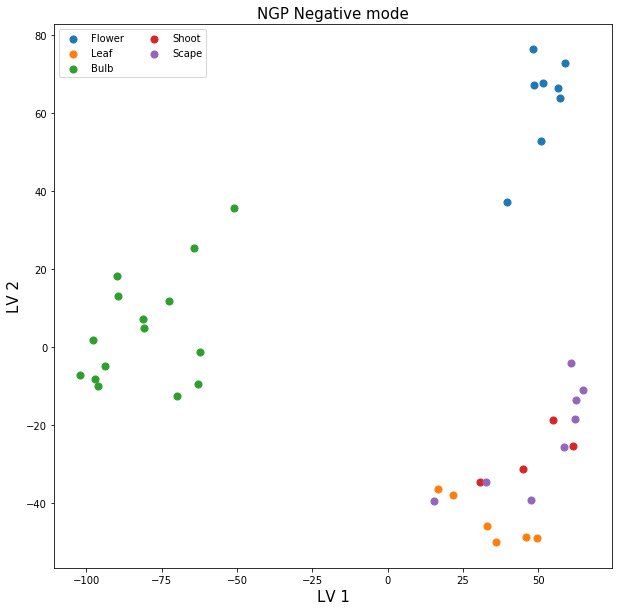

In [91]:
n_components = 8

plsreg_GPneg = ma.PLSscores_with_labels(NGP_neg, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="NGP Negative mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

#### Binary processed data for the negative mode

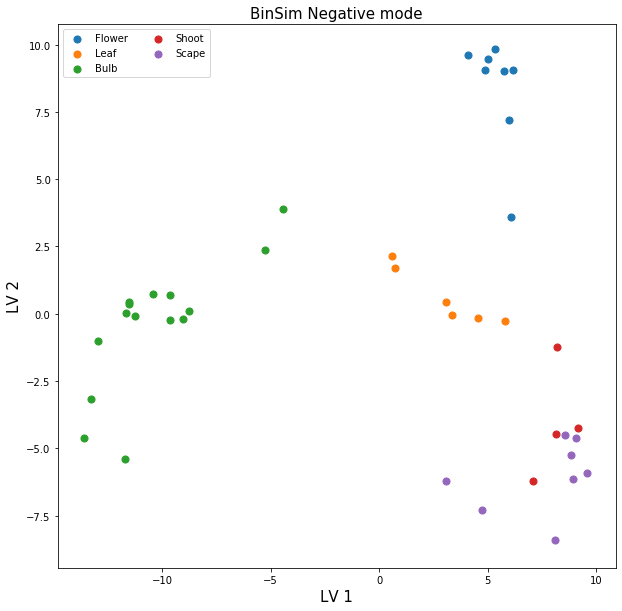

In [92]:
n_components = 8

plsreg_GPneg = ma.PLSscores_with_labels(aligned_neg, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="BinSim Negative mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

### Permutation Tests - Random Forests

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is random forests or pls-da found a significant class structure in the data. 

For that a random k-fold cross-validation is performed on the original dataset (to serve as a comparation point) and 150 permutations of datasets with labels randomly shuffled around with the model being evaluated by how good the predictions the model does of the test data is. 

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random 3-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala2010 - error should be the opposite of the accuracy).

Use of function `permutation_RF` in multianalysis.py

In [93]:
CV = {}
PMs = {}
pvalue = {}

In [94]:
all_data = (Imp_neg, P_neg, NGP_neg, aligned_neg)
names = ('Imp_neg', 'P_neg', 'NGP_neg', 'bin_neg')

for name, data in zip(names, all_data):
    print(f'Permutation test (Random Forest) for {name} ...')
    permuta = ma.permutation_RF(data, iter_num=150, n_fold=4)
    CV[name] = permuta[0]
    PMs[name] = permuta[1]
    pvalue[name] = permuta[2]
    print('Done!')

Permutation test (Random Forest) for Imp_neg ...
Done!
Permutation test (Random Forest) for P_neg ...
Done!
Permutation test (Random Forest) for NGP_neg ...
Done!
Permutation test (Random Forest) for bin_neg ...
Done!


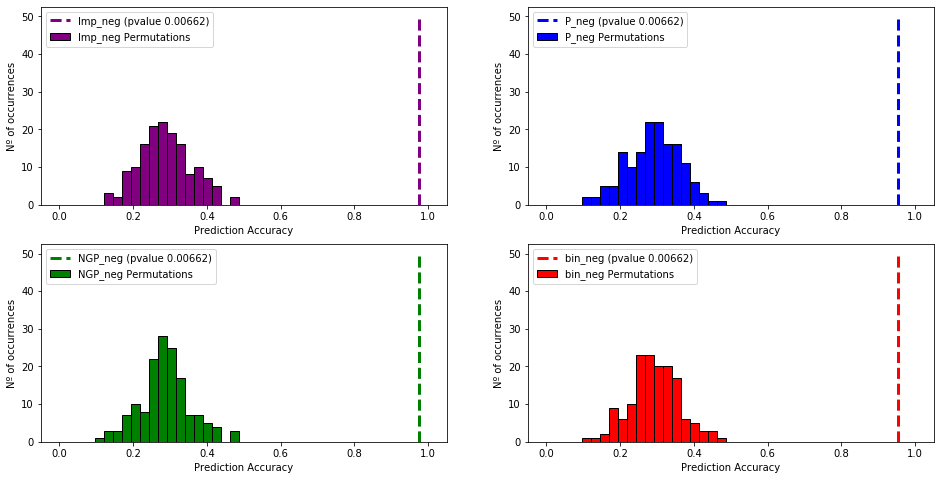

In [95]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['Imp_neg', 'P_neg', 'NGP_neg', 'bin_neg']
color = ['purple','blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_neg.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

### Permutation Tests - PLS-DA

Same explanation as presented for Permutation Tests - Random Forests

In [96]:
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

In [97]:
all_data = (Imp_neg, P_neg, NGP_neg, aligned_neg)
names = ('Imp_neg', 'P_neg', 'NGP_neg', 'bin_neg')

for name, data in zip(names, all_data):
    print(f'permutation test (PLS-DA) for {name} ...')
    permuta = ma.permutation_PLSDA(data, n_comp = 8, iter_num = 150, n_fold = 4)
    CV_PLS[name] = permuta[0]
    PMs_PLS[name] = permuta[1]
    pvalue_PLS[name] = permuta[2]
    print('Done!')

permutation test (PLS-DA) for Imp_neg ...
Done!
permutation test (PLS-DA) for P_neg ...
Done!
permutation test (PLS-DA) for NGP_neg ...
Done!
permutation test (PLS-DA) for bin_neg ...
Done!


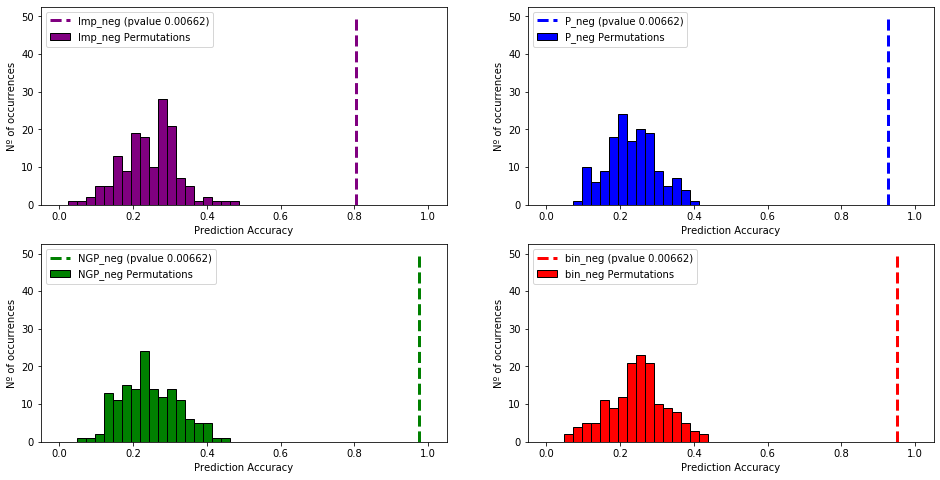

In [98]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['Imp_neg', 'P_neg', 'NGP_neg', 'bin_neg']
color = ['purple','blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_neg.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()